# How to read data from HFD5 files

This is an example to read the data from those HDF5 files generated by LabScript.

The idea is that one just need to give

+ The path where data is stored
+ The date of the data
+ The shot number
+ The path of data in HDF5 file (i.e. the name of group)

It can automatically find the scan axes, and package all of them into an object of DataSet() in xarray package.

Let us start with importing the supporting packages. In order to keep things ealier, here we will import all the packages, but not all of them will be used.

## Import supporting packages

In [1]:
import copy
import glob
from datetime import datetime

# The package for data structure
import xarray as xr
import pandas as pd
import numpy as np

# The packages for working with uncertainties
from uncertainties import ufloat
from uncertainties import unumpy as unp
from uncertainties import umath

# The package for plotting
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 18 # Set the global font size

# -------------- The modules written by us --------------

# The packages for read data
from DataContainer.ReadData import read_hdf5_file, read_hdf5_global, read_hdf5_run_time, read_csv_file

# The packages for data analysis
from Analyser.ImagingAnalyser import ImageAnalyser
from Analyser.FitAnalyser import FitAnalyser
from Analyser.FitAnalyser import ThomasFermi2dModel, DensityProfileBEC2dModel, Polylog22dModel
from Analyser.FFTAnalyser import fft, ifft, fft_nutou
from ToolFunction.ToolFunction import *

# Add errorbar plot to xarray package
from ToolFunction.HomeMadeXarrayFunction import errorbar, dataarray_plot_errorbar
xr.plot.dataarray_plot.errorbar = errorbar
xr.plot.accessor.DataArrayPlotAccessor.errorbar = dataarray_plot_errorbar

If one wants to read tens or few hundreds files, a normal script can finish in several minutes.

## Start a client for parallel computing

In [ ]:
from dask.distributed import Client
client = Client(n_workers=6, threads_per_worker=10, processes=True, memory_limit='10GB')
client

<Client: 'tcp://127.0.0.1:51057' processes=6 threads=60, memory=55.88 GiB>

In [ ]:
imageAnalyser = ImageAnalyser()

## Set global path for experiment

In [68]:
# filepath = "//DyLabNAS/Data/Evaporative_Cooling/2023/05/03/0043/*.h5"
# filepath = "//DyLabNAS/Data/Evaporative_Cooling/2023/04/18/0003/2023-04-18_0003_Evaporative_Cooling_000.h5"

# filepath = "//DyLabNAS/Data/Repetition_scan/2023/04/21/0002/*.h5"

# filepath = r"./testData/0002/*.h5"

# filepath = r"./testData/0002/2023-04-21_0002_Evaporative_Cooling_0.h5"

# filepath = r'd:/Jianshun Gao/Simulations/analyseScripts/testData/0002/2023-04-21_0002_Evaporative_Cooling_0.h5'

# filepath = "//DyLabNAS/Data/Evaporative_Cooling/2023/04/18/0003/*.h5"

filepath = "//DyLabNAS/Data/Evaporative_Cooling/2023/05/04/0000/*.h5"

# filepath = './result_from_experiment/2023-04-24/0013/2023-04-24_0013_Evaporative_Cooling_13.h5'

In [69]:
groupList = [
    "images/MOT_3D_Camera/in_situ_absorption",
    "images/ODT_1_Axis_Camera/in_situ_absorption",
    "images/ODT_2_Axis_Camera/in_situ_absorption",
]

dskey = {
    "images/MOT_3D_Camera/in_situ_absorption": "camera_1",
    "images/ODT_1_Axis_Camera/in_situ_absorption": "camera_2",
    "images/ODT_2_Axis_Camera/in_situ_absorption": "camera_3",
}


In [70]:
img_dir = '//DyLabNAS/Data/'
SequenceName = "Evaporative_Cooling" + "/"
folderPath = img_dir + SequenceName + '2023/05/23'# get_date()

# An example for one experimental run

## Load the data

In [75]:
shotNum = "0069"
filePath = folderPath + "/" + shotNum + "/*.h5"
# filePath = "//DyLabNAS/Data/Evaporative_Cooling/2023/05/12/0065/*.h5"
filePath = './result_from_experiment/2023-04-24/0013/2023-04-24_0013_Evaporative_Cooling_11.h5'

dataSetDict = {
    dskey[groupList[i]]: read_hdf5_file(filePath, groupList[i])
    for i in [0] # range(len(groupList))
}

dataSet = dataSetDict["camera_1"]
dataSet = swap_xy(dataSet)

scanAxis = get_scanAxis(dataSet)

dataSet = auto_rechunk(dataSet)

dataSet = imageAnalyser.get_absorption_images(dataSet)

dataSet

f:\Jianshun\analyseScript\DataContainer\ReadData.py:178: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if not key in datesetOfGlobal.scanAxis


<xarray.Dataset>
Dimensions:     (y: 1200, x: 1920)
Dimensions without coordinates: y, x
Data variables:
    atoms       (y, x) uint16 dask.array<chunksize=(1200, 1920), meta=np.ndarray>
    background  (y, x) uint16 dask.array<chunksize=(1200, 1920), meta=np.ndarray>
    dark        (y, x) uint16 dask.array<chunksize=(1200, 1920), meta=np.ndarray>
    shotNum     <U2 '11'
    OD          (y, x) float64 dask.array<chunksize=(1200, 1920), meta=np.ndarray>
Attributes: (12/96)
    TOF_free:                          0.02
    abs_img_freq:                      110.858
    absorption_imaging_flag:           True
    backup_data:                       True
    blink_off_time:                    nan
    blink_on_time:                     nan
    ...                                ...
    y_offset:                          0
    y_offset_img:                      0
    z_offset:                          0.189
    z_offset_img:                      0.189
    scanAxis:                          []
    scanAxisLength:                    []

## Calculate an plot OD images

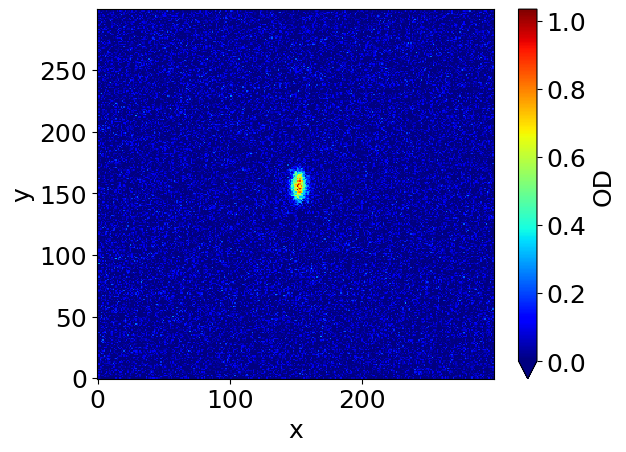

In [76]:
# imageAnalyser.center = (960, 1040)
# imageAnalyser.span = (100, 100)
# imageAnalyser.fraction = (0.1, 0.1)

imageAnalyser.center = (960, 875)
imageAnalyser.span = (300, 300)
imageAnalyser.fraction = (0.1, 0.1)

dataSet_cropOD = imageAnalyser.crop_image(dataSet.OD)
dataSet_cropOD = imageAnalyser.substract_offset(dataSet_cropOD).load()

dataSet_cropOD.plot.pcolormesh(cmap='jet', vmin=0, col=scanAxis[0], row=scanAxis[1])
plt.show()